<a href="https://colab.research.google.com/github/SullyC25/Week4/blob/main/Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# --- Paths (edit only if yours differ) ---
ERA_FILE   = "/content/drive/MyDrive/Validation/5a78ff30ba72789b94ae8a2ab12aa0c6.nc"
PAIRS_FILE = "/content/drive/MyDrive/CollocationV3/s3_j3_pairs_baseline_qc.parquet"
OUT_DIR    = "/content/drive/MyDrive/Validation/ERA5_Validation"

import os
os.makedirs(OUT_DIR, exist_ok=True)
print("OUT_DIR =", OUT_DIR)

# --- Imports ---
import xarray as xr
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
OUT_DIR = /content/drive/MyDrive/Validation/ERA5_Validation


In [ ]:
def load_era5_daily(path, alongshore_azimuth_deg=55.0):
    ds = xr.open_dataset(path)

    # Harmonize coord names (lat/lon vs latitude/longitude)
    rename_map = {}
    if "latitude" not in ds.coords and "lat" in ds.coords:   rename_map["lat"] = "latitude"
    if "longitude" not in ds.coords and "lon" in ds.coords:  rename_map["lon"] = "longitude"
    if rename_map:
        ds = ds.rename(rename_map)

    # Find time-like dimension (often 'valid_time')
    def find_time_dim(_ds):
        for name in list(_ds.dims) + list(_ds.coords):
            if "time" in name:
                return name
        for v in ["u10","v10","msl"]:
            if v in _ds:
                for d in _ds[v].dims:
                    if "time" in d:
                        return d
        if "valid_time" in _ds.variables:
            return "valid_time"
        return None

    time_dim = find_time_dim(ds)
    if time_dim is None:
        raise ValueError(f"No time-like dimension found. Dims: {ds.dims}")

    # Promote valid_time to coord if needed, then rename to 'time'
    if time_dim == "valid_time" and "valid_time" in ds.variables and "valid_time" not in ds.coords:
        ds = ds.set_coords("valid_time")
    if time_dim != "time":
        ds = ds.rename({time_dim: "time"})

    # Average ensemble/expver if present
    for dim in ["number", "expver"]:
        if dim in ds.dims:
            ds = ds.mean(dim=dim, skipna=True)

    # Spatial mean over the box (if gridded)
    for dim in ["latitude", "longitude"]:
        if dim in ds.dims:
            ds = ds.mean(dim=dim, skipna=True)

    # Ensure datetime
    if not np.issubdtype(ds["time"].dtype, np.datetime64):
        ds = ds.assign_coords(time=pd.to_datetime(ds["time"].values))
    ds = ds.sortby("time")

    # Required vars
    needed = [v for v in ["u10","v10","msl"] if v in ds]
    if len(needed) < 3:
        raise KeyError(f"ERA file missing one of u10/v10/msl. Found: {list(ds.data_vars)}")

    # DataFrame (numeric only)
    era = ds[needed].to_dataframe()
    era = era.apply(pd.to_numeric, errors="coerce").dropna(how="all")
    era.index = pd.to_datetime(era.index)
    era = era.rename(columns={"msl":"mslp"})

    # Derived fields
    era["wind_speed"] = np.sqrt(era["u10"]**2 + era["v10"]**2)
    RHO, G = 1025.0, 9.81
    era["ib_meters"] = -(era["mslp"] - era["mslp"].mean())/(RHO*G)

    theta = np.deg2rad(alongshore_azimuth_deg)
    era["u_along"] = era["u10"]*np.cos(theta) + era["v10"]*np.sin(theta)

    # Daily series
    era_day = era.resample("1D").mean(numeric_only=True)
    return era_day

era_day = load_era5_daily(ERA_FILE, alongshore_azimuth_deg=55.0)
print("✅ ERA5 loaded & daily:", ERA_FILE, "| rows:", len(era_day))
display(era_day.head())


✅ ERA5 loaded & daily: /content/drive/MyDrive/Validation/5a78ff30ba72789b94ae8a2ab12aa0c6.nc | rows: 184


,u10,v10,mslp,number,expver,wind_speed,ib_meters,u_along
time,,,,,,,,
2024-07-01,2.707029,3.919179,100042.460938,0.0,1.0,4.763189,0.072032,4.763092
2024-07-02,2.548585,3.045256,99976.687500,0.0,1.0,3.971004,0.078573,3.956336
2024-07-03,0.966084,2.920357,100046.562500,0.0,1.0,3.076004,0.071624,2.946339
2024-07-04,0.484976,3.127604,100306.523438,0.0,1.0,3.164981,0.045771,2.840154
2024-07-05,0.166617,4.148642,100317.453125,0.0,1.0,4.151986,0.044684,3.493936


In [ ]:
pairs = pd.read_parquet(PAIRS_FILE)

# Pick time column: prefer S3, else J3, else any 'time'
if "time_s3" in pairs.columns:
    TIME_COL = "time_s3"
elif "j3_time" in pairs.columns:
    TIME_COL = "j3_time"
else:
    time_candidates = [c for c in pairs.columns if "time" in c.lower()]
    if not time_candidates:
        raise ValueError("No time column found in pairs file.")
    TIME_COL = time_candidates[0]

pairs[TIME_COL] = pd.to_datetime(pairs[TIME_COL])
print("Using TIME_COL =", TIME_COL)

# Detect SLA columns: S3 has 'sla_s3'; J3 try SLA first, else fallback to ADT
cols = pairs.columns.tolist()
S3_COL = "sla_s3"

candidates_j3 = [
    "sla_j3", "sla_bc_j3", "sla_anom_j3", "sla_j3_bc", "sla_corr_j3",
    "sla_j3_qc", "sla_qc_j3"
]
J3_COL = next((c for c in candidates_j3 if c in cols), None)
if J3_COL is None:
    if "adt_j3" in cols:
        J3_COL = "adt_j3"
        print("⚠️  Fallback: using 'adt_j3' as J3 SLA proxy (ADT ≠ SLA). Override J3_COL if you have a true SLA.")
    else:
        j3_like = [c for c in cols if "_j3" in c.lower() or "j3_" in c.lower()]
        raise ValueError(f"No J3 SLA-like column found. Looked for {candidates_j3}. J3-ish: {j3_like}")

print(f"Using S3_COL={S3_COL}, J3_COL={J3_COL}")

# Keep only needed + numeric
pairs = pairs[[TIME_COL, S3_COL, J3_COL]].copy()
pairs[S3_COL] = pd.to_numeric(pairs[S3_COL], errors="coerce")
pairs[J3_COL] = pd.to_numeric(pairs[J3_COL], errors="coerce")
pairs = pairs.dropna(subset=[S3_COL, J3_COL])

# Daily aggregates to align with ERA
pairs["date"] = pd.to_datetime(pairs[TIME_COL].dt.date)
pairs = pairs.rename(columns={S3_COL:"sla_s3", J3_COL:"sla_j3"})
pairs["delta"] = pairs["sla_s3"] - pairs["sla_j3"]

pairs_day = pairs.groupby("date", as_index=True).mean(numeric_only=True).sort_index()
print("✅ Pairs daily prepared. rows:", len(pairs_day))
display(pairs_day.head())


Using TIME_COL = time_s3
Using S3_COL=sla_s3, J3_COL=sla_j3
✅ Pairs daily prepared. rows: 22


,sla_s3,sla_j3,delta
date,,,
2024-07-01,0.242388,0.268132,-0.025744
2024-07-13,0.098684,0.169300,-0.070616
2024-07-19,0.226544,0.273166,-0.046622
2024-07-25,0.146082,0.211398,-0.065315
2024-08-01,0.264092,0.329248,-0.065156


In [ ]:
df = pairs_day.merge(era_day, left_index=True, right_index=True, how="inner").sort_index()
print("Merged rows:", len(df))
display(df.head())

def r(x):
    try: return f"{x:.3f}"
    except: return "nan"

metrics = pd.Series({
    "N days": len(df),
    "Corr(S3, −MSLP)": df["sla_s3"].corr(-df["mslp"]),
    "Corr(J3, −MSLP)": df["sla_j3"].corr(-df["mslp"]),
    "Corr(Δ=S3−J3, U_along)": df["delta"].corr(df["u_along"]),
    "Corr(S3, WindSpeed)": df["sla_s3"].corr(df["wind_speed"]),
    "Corr(J3, WindSpeed)": df["sla_j3"].corr(df["wind_speed"]),
}).round(3)

display(metrics)
metrics.to_csv(os.path.join(OUT_DIR, "validation_metrics_raw.csv"))
print("✅ Saved:", os.path.join(OUT_DIR, "validation_metrics_raw.csv"))


Merged rows: 22


,sla_s3,sla_j3,delta,u10,v10,mslp,number,expver,wind_speed,ib_meters,u_along
2024-07-01,0.242388,0.268132,-0.025744,2.707029,3.919179,100042.460938,0.0,1.0,4.763189,0.072032,4.763092
2024-07-13,0.098684,0.169300,-0.070616,0.356396,1.833714,99940.046875,0.0,1.0,1.868027,0.082217,1.706511
2024-07-19,0.226544,0.273166,-0.046622,-3.405435,2.036680,99867.429688,0.0,1.0,3.968003,0.089439,-0.284927
2024-07-25,0.146082,0.211398,-0.065315,1.244560,1.555470,99395.039062,0.0,1.0,1.992089,0.136418,1.988017
2024-08-01,0.264092,0.329248,-0.065156,0.496695,3.615556,99962.929688,0.0,1.0,3.649514,0.079941,3.246583


,0
N days,22.000
"Corr(S3, −MSLP)",-0.324
"Corr(J3, −MSLP)",-0.103
"Corr(Δ=S3−J3, U_along)",-0.251
"Corr(S3, WindSpeed)",0.471
"Corr(J3, WindSpeed)",0.510


✅ Saved: /content/drive/MyDrive/Validation/ERA5_Validation/validation_metrics_raw.csv


In [ ]:
df["sla_s3_ibc"] = df["sla_s3"] - df["ib_meters"]
df["sla_j3_ibc"] = df["sla_j3"] - df["ib_meters"]

metrics_ibc = pd.Series({
    "Corr(S3_ibc, −MSLP)": df["sla_s3_ibc"].corr(-df["mslp"]),
    "Corr(J3_ibc, −MSLP)": df["sla_j3_ibc"].corr(-df["mslp"]),
    "Corr(Δ_ibc, U_along)": (df["sla_s3_ibc"]-df["sla_j3_ibc"]).corr(df["u_along"]),
}).round(3)

display(metrics_ibc)
metrics_ibc.to_csv(os.path.join(OUT_DIR, "validation_metrics_ibc.csv"))
print("✅ Saved:", os.path.join(OUT_DIR, "validation_metrics_ibc.csv"))


,0
"Corr(S3_ibc, −MSLP)",-0.659
"Corr(J3_ibc, −MSLP)",-0.623
"Corr(Δ_ibc, U_along)",-0.251


✅ Saved: /content/drive/MyDrive/Validation/ERA5_Validation/validation_metrics_ibc.csv


In [ ]:
def lag_corr(x, y, lags=range(-14,15)):
    vals = []
    for L in lags:
        vals.append(y.corr(x.shift(L)))
    return pd.Series(vals, index=lags)

lags = range(-14,15)
lc_s3 = lag_corr(df["u_along"], df["sla_s3"], lags)
lc_j3 = lag_corr(df["u_along"], df["sla_j3"], lags)

lag_df = pd.DataFrame({"lag_days": list(lags), "corr_S3": lc_s3.values, "corr_J3": lc_j3.values})
lag_df.to_csv(os.path.join(OUT_DIR, "lagcorr_along_vs_sla.csv"), index=False)

print("Lag (S3) peak:", int(lc_s3.idxmax()), "→", f"{lc_s3.max():.3f}")
print("Lag (J3) peak:", int(lc_j3.idxmax()), "→", f"{lc_j3.max():.3f}")
print("✅ Saved:", os.path.join(OUT_DIR, "lagcorr_along_vs_sla.csv"))


Lag (S3) peak: -8 → 0.726
Lag (J3) peak: -12 → 0.772
✅ Saved: /content/drive/MyDrive/Validation/ERA5_Validation/lagcorr_along_vs_sla.csv


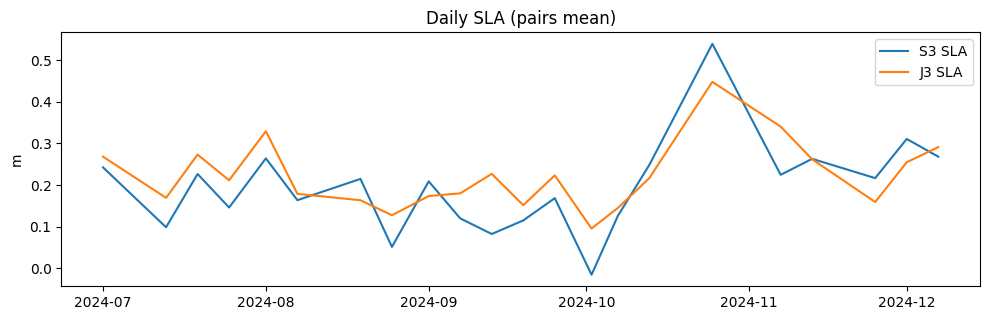

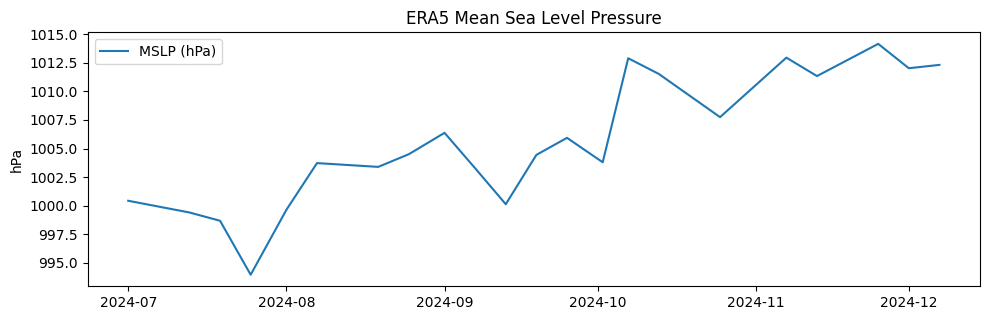

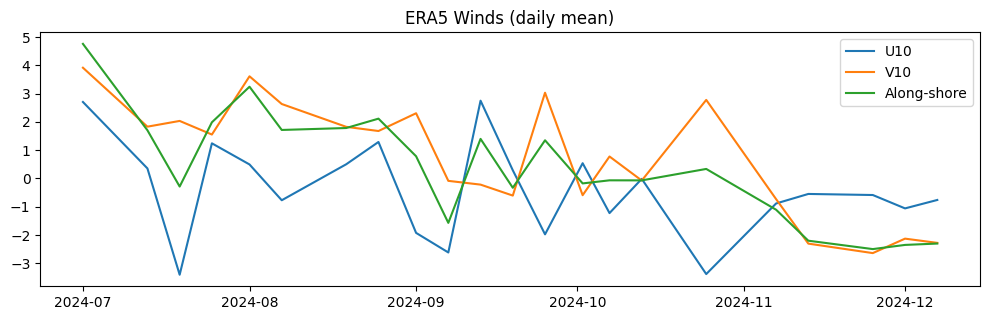

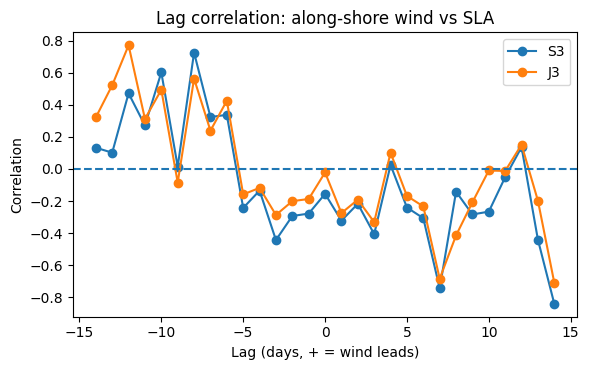

In [ ]:
plt.figure(figsize=(10,3.3))
plt.plot(df.index, df["sla_s3"], label="S3 SLA")
plt.plot(df.index, df["sla_j3"], label="J3 SLA")
plt.ylabel("m"); plt.title("Daily SLA (pairs mean)"); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "timeseries_sla.png"), dpi=200)

plt.figure(figsize=(10,3.3))
plt.plot(df.index, df["mslp"]/100, label="MSLP (hPa)")
plt.ylabel("hPa"); plt.title("ERA5 Mean Sea Level Pressure"); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "timeseries_mslp.png"), dpi=200)

plt.figure(figsize=(10,3.3))
plt.plot(df.index, df["u10"], label="U10")
plt.plot(df.index, df["v10"], label="V10")
plt.plot(df.index, df["u_along"], label="Along-shore")
plt.title("ERA5 Winds (daily mean)"); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "timeseries_winds.png"), dpi=200)

plt.figure(figsize=(6,3.8))
plt.plot(lc_s3.index, lc_s3.values, marker="o", label="S3")
plt.plot(lc_j3.index, lc_j3.values, marker="o", label="J3")
plt.axhline(0, ls="--"); plt.xlabel("Lag (days, + = wind leads)"); plt.ylabel("Correlation")
plt.title("Lag correlation: along-shore wind vs SLA"); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "lagcorr_along_vs_sla.png"), dpi=200)

#print("📁 Saved plots to:", OUT_DIR)


In [ ]:
# --- Helpers (run once) ---
import matplotlib.dates as mdates

def shade_monsoon(ax, start="2024-07-01", end="2024-10-31", alpha=0.12):
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color="tab:blue", alpha=alpha, lw=0)

def add_month_locator(ax):
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    for label in ax.get_xticklabels():
        label.set_rotation(0)


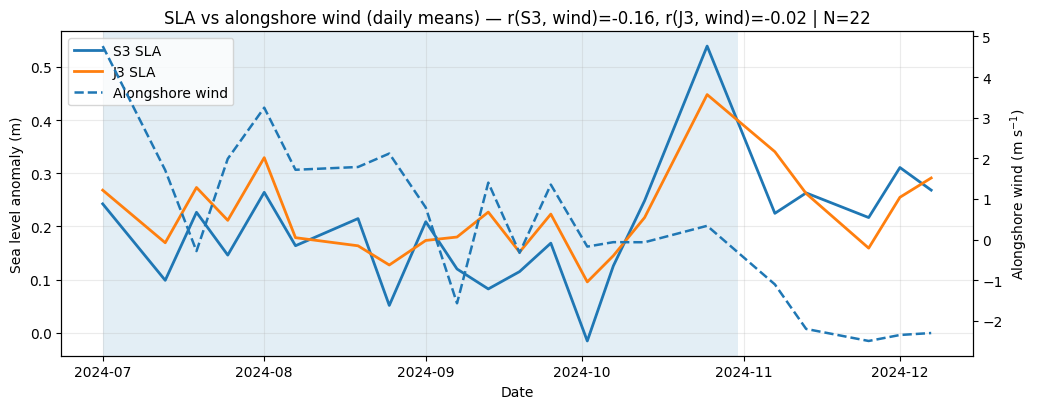

Saved: /content/drive/MyDrive/Validation/ERA5_Validation/overlay_sla_vs_alongshore.png


In [ ]:
# --- Overlay: SLA vs alongshore wind (dual y-axes) ---
fig, ax = plt.subplots(figsize=(10.5, 4.2))

# Left axis: SLA (both missions)
l1, = ax.plot(df.index, df["sla_s3"],  lw=2.0, label="S3 SLA")
l2, = ax.plot(df.index, df["sla_j3"],  lw=2.0, label="J3 SLA")

ax.set_ylabel("Sea level anomaly (m)")
ax.set_xlabel("Date")

# Right axis: alongshore wind
ax2 = ax.twinx()
l3, = ax2.plot(df.index, df["u_along"], lw=1.8, ls="--", label="Alongshore wind")
ax2.set_ylabel("Alongshore wind (m s$^{-1}$)")

# Cosmetics
shade_monsoon(ax)
add_month_locator(ax)
ax.grid(True, alpha=0.25)

# Title + inline correlation (same-day)
r_s3 = df["sla_s3"].corr(df["u_along"])
r_j3 = df["sla_j3"].corr(df["u_along"])
N    = len(df)
ax.set_title(f"SLA vs alongshore wind (daily means) — r(S3, wind)={r_s3:.2f}, r(J3, wind)={r_j3:.2f} | N={N}")

# Single legend combining both axes
lines = [l1, l2, l3]
labels = [ln.get_label() for ln in lines]
ax.legend(lines, labels, loc="upper left", frameon=True)

out_png = os.path.join(OUT_DIR, "overlay_sla_vs_alongshore.png")
plt.tight_layout(); plt.savefig(out_png, dpi=200); plt.show()
print("Saved:", out_png)


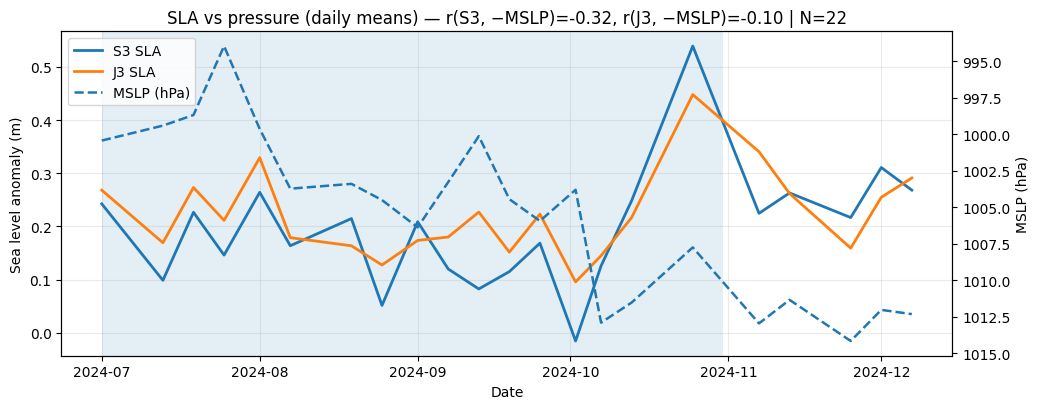

Saved: /content/drive/MyDrive/Validation/ERA5_Validation/overlay_sla_vs_mslp.png


In [ ]:
# --- Overlay: SLA vs MSLP (dual y-axes, inverted pressure axis) ---
fig, ax = plt.subplots(figsize=(10.5, 4.2))

# Left axis: SLA (both missions)
l1, = ax.plot(df.index, df["sla_s3"],  lw=2.0, label="S3 SLA")
l2, = ax.plot(df.index, df["sla_j3"],  lw=2.0, label="J3 SLA")
ax.set_ylabel("Sea level anomaly (m)")
ax.set_xlabel("Date")

# Right axis: MSLP (hPa), invert to visually show IB (↓ pressure → ↑ SLA)
ax2 = ax.twinx()
l3, = ax2.plot(df.index, df["mslp"]/100.0, lw=1.8, ls="--", label="MSLP (hPa)")
ax2.set_ylabel("MSLP (hPa)")
ax2.invert_yaxis()

# Cosmetics
shade_monsoon(ax)
add_month_locator(ax)
ax.grid(True, alpha=0.25)

# Title + inline correlation with -MSLP (hydrostatic sign)
r_s3_p = df["sla_s3"].corr(-df["mslp"])
r_j3_p = df["sla_j3"].corr(-df["mslp"])
N      = len(df)
ax.set_title(f"SLA vs pressure (daily means) — r(S3, −MSLP)={r_s3_p:.2f}, r(J3, −MSLP)={r_j3_p:.2f} | N={N}")

# Legend
lines = [l1, l2, l3]
labels = [ln.get_label() for ln in lines]
ax.legend(lines, labels, loc="upper left", frameon=True)

out_png = os.path.join(OUT_DIR, "overlay_sla_vs_mslp.png")
plt.tight_layout(); plt.savefig(out_png, dpi=200); plt.show()
print("Saved:", out_png)
